<ipython-input-16-51ae8adc9faf>:2: DtypeWarning: Columns (15,17,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


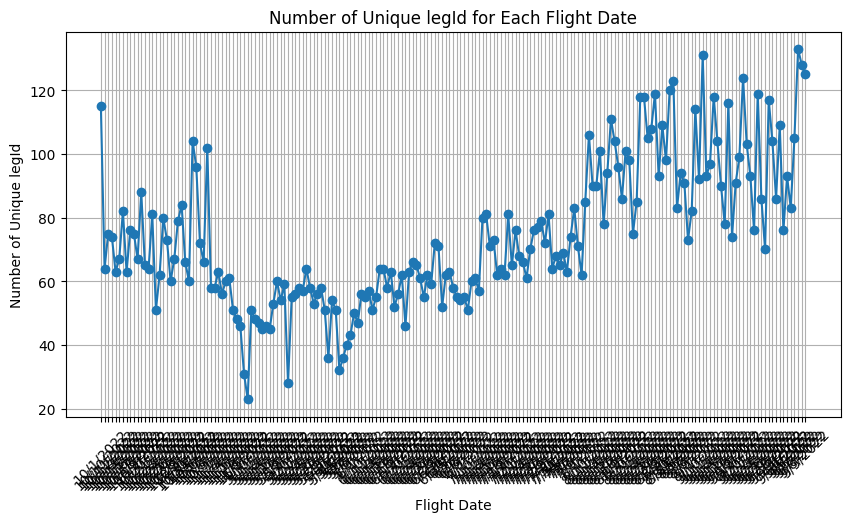

In [16]:
file_path = '/content/drive/MyDrive/1_ord_lax_sorted_wDaysBeforeDeparture_bestTimePurchase_day_month_wDayOfWeek_wHolidays_wDurationMinutes_wCount_time_filterd_14_layovers.csv'
data = pd.read_csv(file_path)
unique_legId_count = data.drop_duplicates(subset=['flightDate', 'legId']).groupby('flightDate')['legId'].nunique().reset_index()
unique_legId_count.columns = ['flightDate', 'unique_legId_count']

plt.figure(figsize=(10, 5))
plt.plot(unique_legId_count['flightDate'], unique_legId_count['unique_legId_count'], marker='o')
plt.xlabel('Flight Date')
plt.ylabel('Number of Unique legId')
plt.title('Number of Unique legId for Each Flight Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [4]:
import time
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from dask.diagnostics import ProgressBar


file_path ='/content/drive/MyDrive/1_ord_lax_sorted_wDaysBeforeDeparture_bestTimePurchase_day_month_wDayOfWeek_wHolidays_wDurationMinutes_wCount_time_filterd_14_layovers.csv'
df = pd.read_csv(file_path)

columns_to_keep = [
    'daysBeforeFlight',
    'flightDay', 'flightMonth',
    'flightDayOfWeek', 'nearHoliday', 'bestTimeToPurchase',
    'departureHour', 'departureMinute', 'arrivalMinute', 'arrivalHour', 'travelDurationMinutes'
]


df_filtered = df[columns_to_keep]

# Sample 10% of the dataset
df_sampled = df_filtered.sample(frac=0.1, random_state=42)

# Define features and target variable
X = df_sampled.drop('bestTimeToPurchase', axis=1)
y = df_sampled['bestTimeToPurchase']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Measure time to fit a single RandomForestRegressor model
rf_regressor = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=None,
                                     min_samples_split=2, min_samples_leaf=1, bootstrap=True)
start_time = time.time()
rf_regressor.fit(X_train, y_train)
single_fit_time = time.time() - start_time
print(f"Time to fit a single model: {single_fit_time:.2f} seconds")

# Estimate total time for GridSearchCV
total_candidates = 648
n_folds = 5
estimated_total_time = single_fit_time * total_candidates * n_folds
print(f"Estimated total time for GridSearchCV: {estimated_total_time / 60:.2f} minutes")

<ipython-input-4-4a40b45bc89b>:9: DtypeWarning: Columns (15,17,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Time to fit a single model: 9.90 seconds
Estimated total time for GridSearchCV: 534.68 minutes


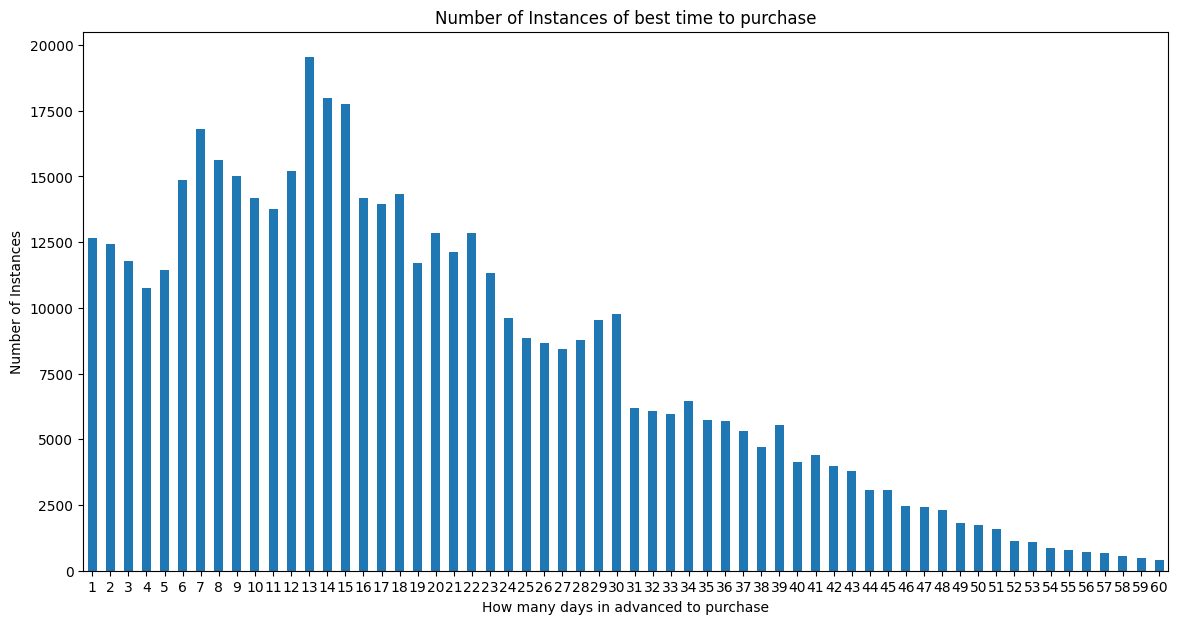

In [5]:
df_days_before_flight_count = df_filtered['bestTimeToPurchase'].value_counts().sort_index()
plt.figure(figsize=(14, 7))
df_days_before_flight_count.plot(kind='bar')
plt.title('Number of Instances of best time to purchase')
plt.xlabel('How many days in advanced to purchase')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

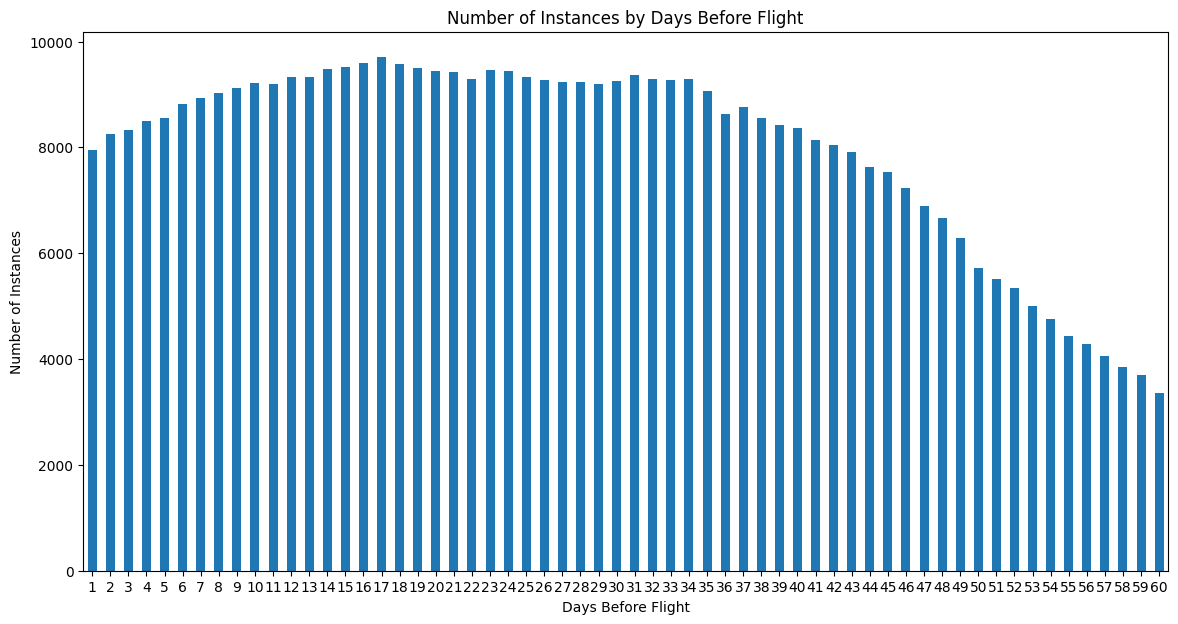

In [6]:
df_days_before_flight_count = df_filtered['daysBeforeFlight'].value_counts().sort_index()
plt.figure(figsize=(14, 7))
df_days_before_flight_count.plot(kind='bar')
plt.title('Number of Instances by Days Before Flight')
plt.xlabel('Days Before Flight')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()

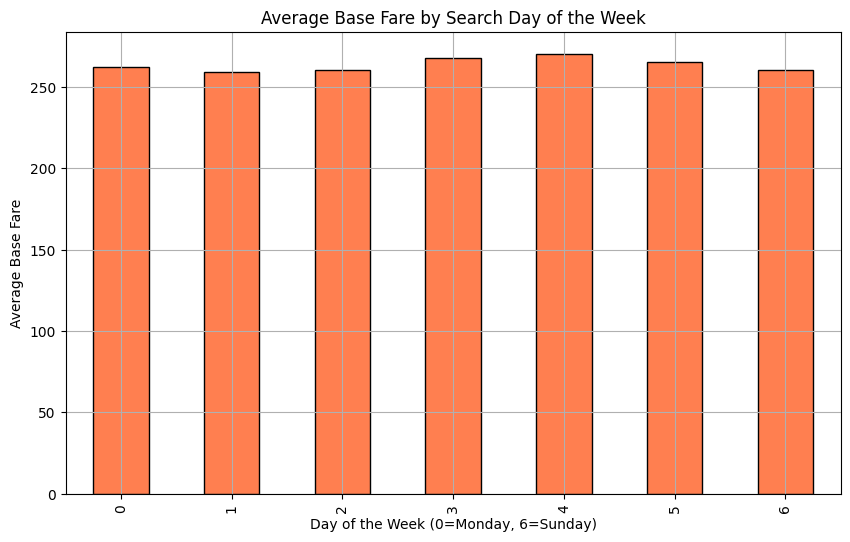

In [7]:

plt.figure(figsize=(10, 6))
df.groupby('searchDayOfWeek')['baseFare'].mean().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Base Fare by Search Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Base Fare')
plt.grid(True)
plt.show()

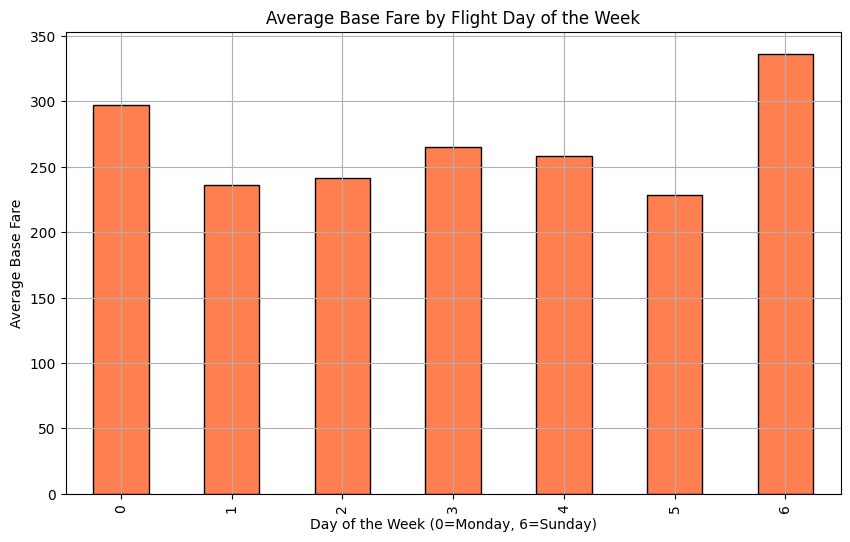

In [8]:

plt.figure(figsize=(10, 6))
df.groupby('flightDayOfWeek')['baseFare'].mean().plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Base Fare by Flight Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Base Fare')
plt.grid(True)
plt.show()

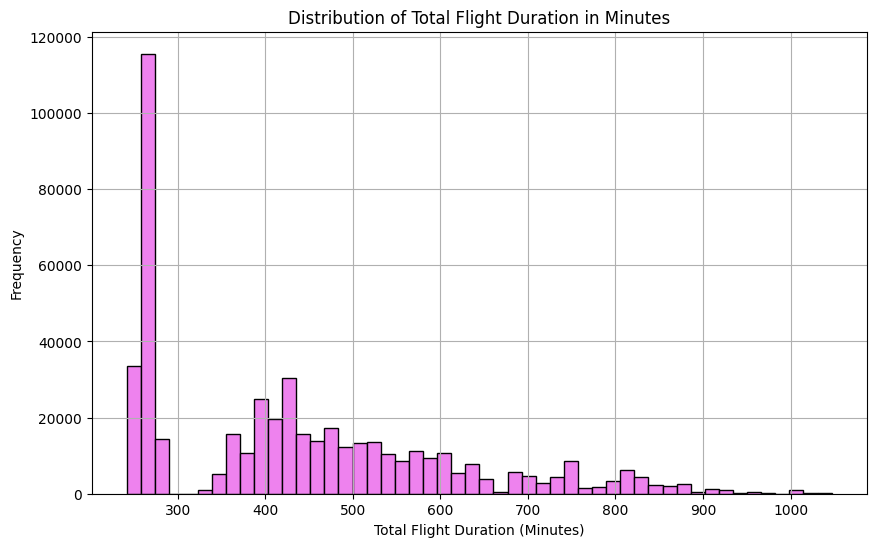

In [9]:

plt.figure(figsize=(10, 6))
plt.hist(df['travelDurationMinutes'], bins=50, color='violet', edgecolor='black')
plt.title('Distribution of Total Flight Duration in Minutes')
plt.xlabel('Total Flight Duration (Minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

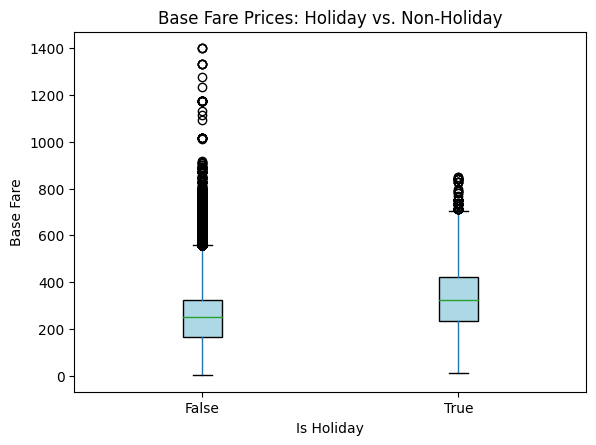

In [ ]:
# Holiday vs. Non-Holiday Prices
plt.figure(figsize=(10, 6))
df.boxplot(column='baseFare', by='isHoliday', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Base Fare Prices: Holiday vs. Non-Holiday')
plt.suptitle('')  # Suppress the default title to avoid redundancy
plt.xlabel('Is Holiday')
plt.ylabel('Base Fare')
plt.show()

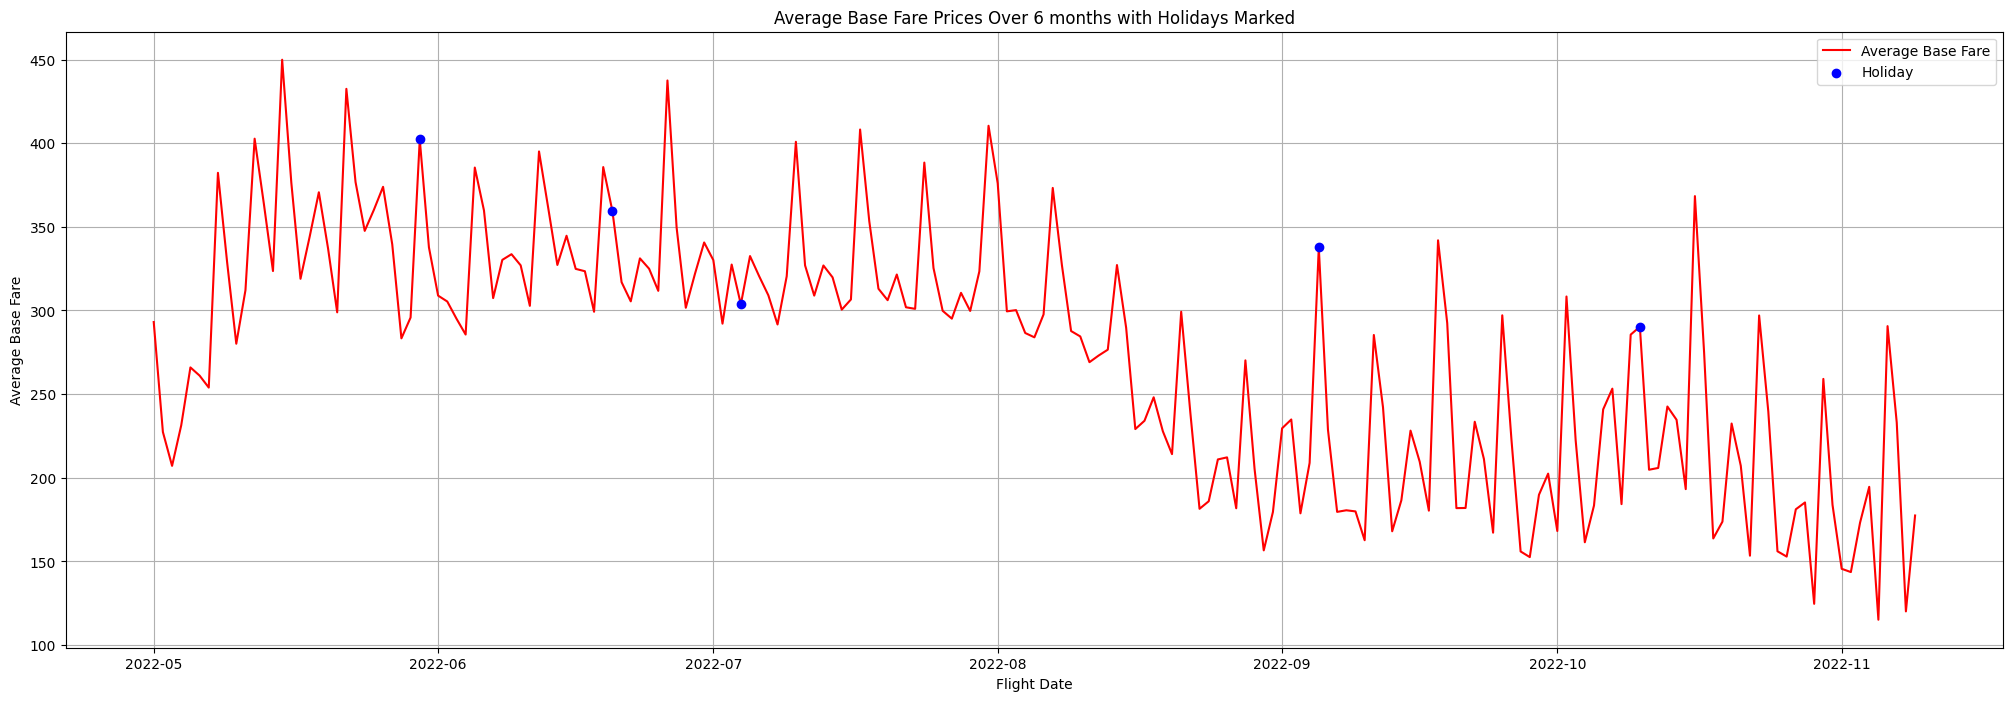

In [10]:

df['flightDate'] = pd.to_datetime(df['flightDate'])

# Calculate the average base fare per day
average_base_fare_per_day = df.groupby('flightDate')['baseFare'].mean().reset_index()

# Merge the holiday information
holiday_info = df[['flightDate', 'isHoliday']].drop_duplicates().reset_index(drop=True)
average_base_fare_per_day = average_base_fare_per_day.merge(holiday_info, on='flightDate', how='left')

# Plot the average base fare over time as a line graph
plt.figure(figsize=(25, 8))
plt.plot(average_base_fare_per_day['flightDate'], average_base_fare_per_day['baseFare'], color='red', label='Average Base Fare')

# Add blue dots where isHoliday is True
holiday_dates = average_base_fare_per_day[average_base_fare_per_day['isHoliday'] == True]
plt.scatter(holiday_dates['flightDate'], holiday_dates['baseFare'], color='blue', label='Holiday', zorder=5)

plt.title('Average Base Fare Prices Over 6 months with Holidays Marked')
plt.xlabel('Flight Date')
plt.ylabel('Average Base Fare')
plt.legend()
plt.grid(True)
plt.show()

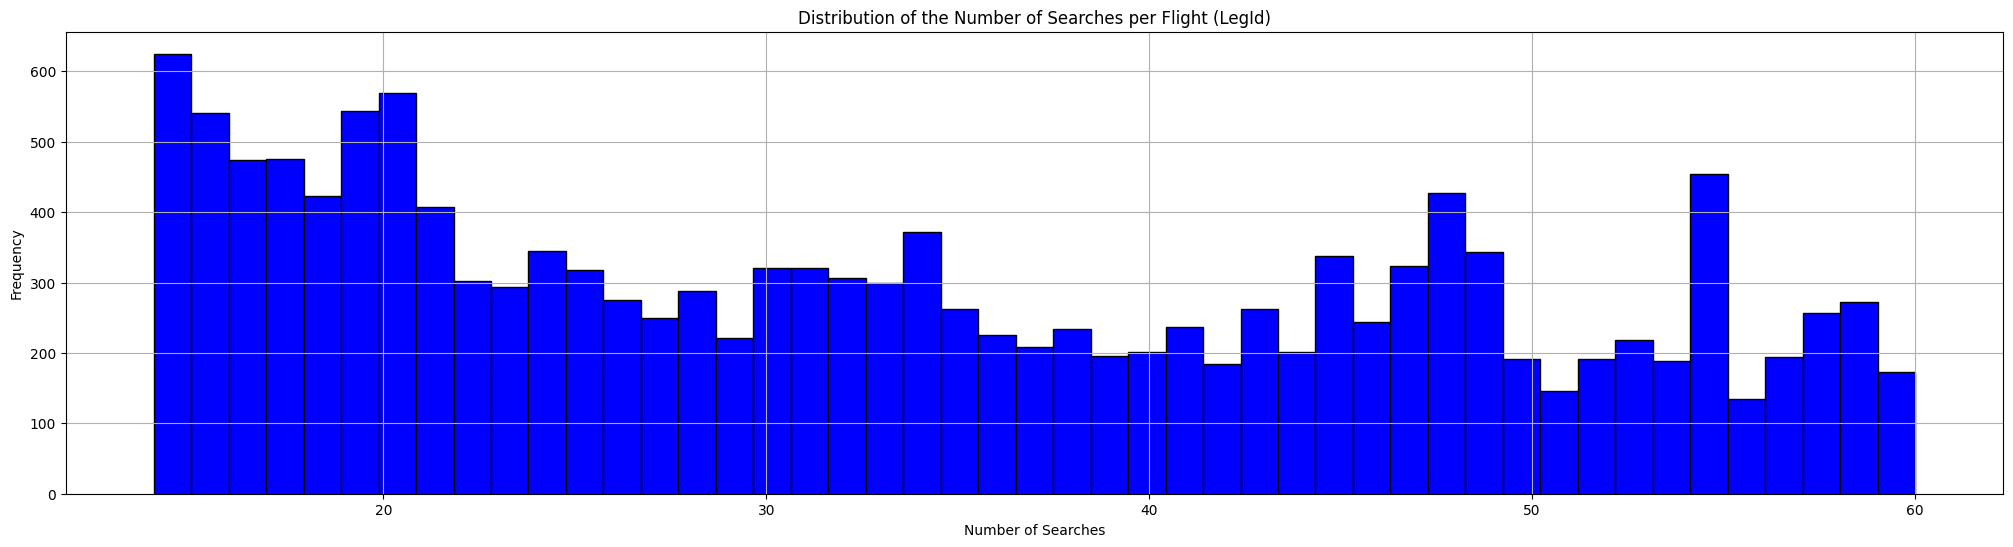

In [11]:
# Flight Searches
plt.figure(figsize=(25, 6))
df['legId'].value_counts().plot(kind='hist', bins=47, color='blue', edgecolor='black')
plt.title('Distribution of the Number of Searches per Flight (LegId)')
plt.xlabel('Number of Searches')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

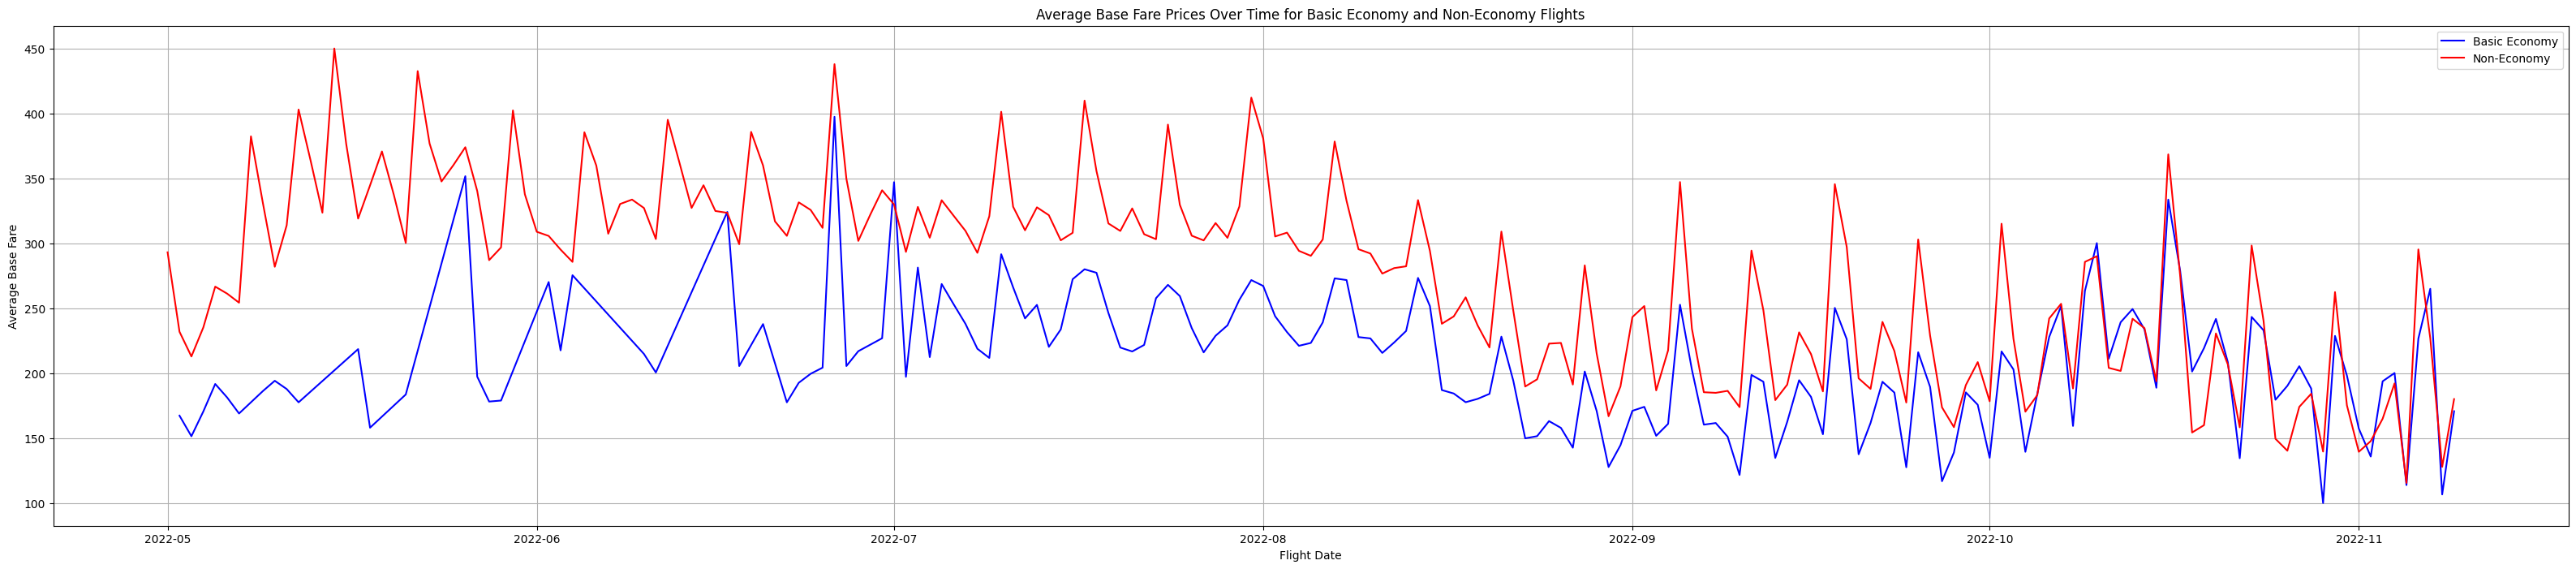

In [12]:

df['flightDate'] = pd.to_datetime(df['flightDate'])

    # Calculate the average base fare per day for basic economy and non-economy flights
basic_economy_prices = df[df['isBasicEconomy'] == True].groupby('flightDate')['baseFare'].mean().reset_index()
non_economy_prices = df[df['isBasicEconomy'] == False].groupby('flightDate')['baseFare'].mean().reset_index()

    # Plot the average base fare over time
plt.figure(figsize=(40, 8))

    # Basic economy line graph
plt.plot(basic_economy_prices['flightDate'], basic_economy_prices['baseFare'], color='blue', label='Basic Economy')

    # Non-economy line graph
plt.plot(non_economy_prices['flightDate'], non_economy_prices['baseFare'], color='red', label='Non-Economy')

plt.title('Average Base Fare Prices Over Time for Basic Economy and Non-Economy Flights')
plt.xlabel('Flight Date')
plt.ylabel('Average Base Fare')
plt.legend()
plt.grid(True)

    # Show the pl
plt.show()

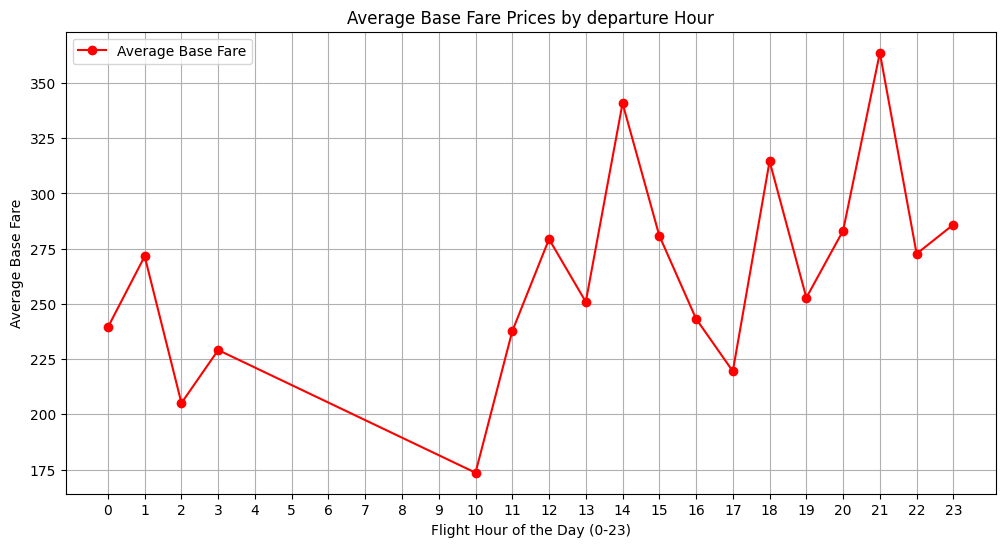

In [13]:
# Calculate the average base fare per flight hour
average_base_fare_per_hour = df.groupby('departureHour')['baseFare'].mean().reset_index()

# Plot the average base fare over the 24 hours
plt.figure(figsize=(12, 6))
plt.plot(average_base_fare_per_hour['departureHour'], average_base_fare_per_hour['baseFare'], marker='o', linestyle='-', color='red', label='Average Base Fare')

plt.title('Average Base Fare Prices by departure Hour')
plt.xlabel('Flight Hour of the Day (0-23)')
plt.ylabel('Average Base Fare')
plt.xticks(range(24))  # Ensure all 24 hours are shown on the x-axis
plt.grid(True)
plt.legend()
plt.show()

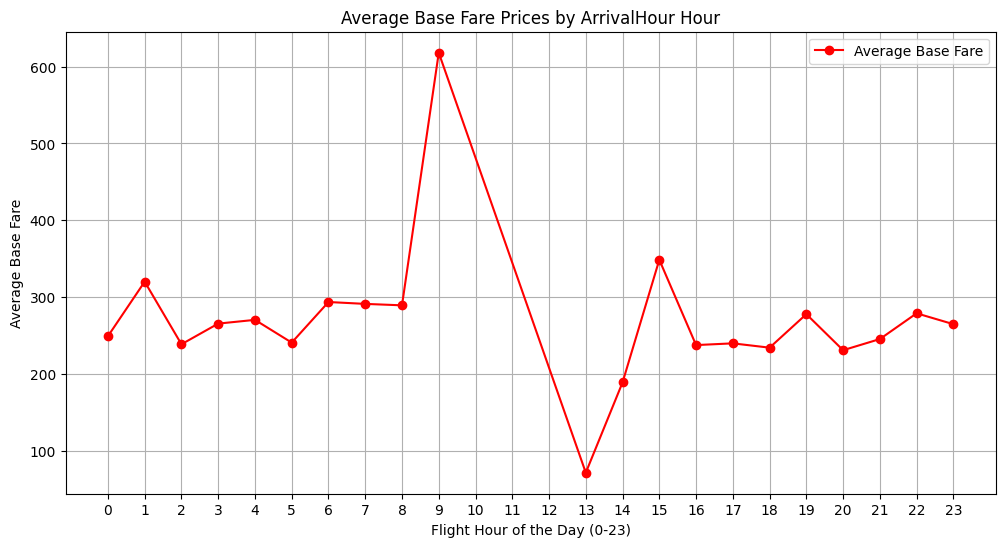

In [15]:
# Calculate the average base fare per flight hour
average_base_fare_per_hour = df.groupby('arrivalHour')['baseFare'].mean().reset_index()

# Plot the average base fare over the 24 hours
plt.figure(figsize=(12, 6))
plt.plot(average_base_fare_per_hour['arrivalHour'], average_base_fare_per_hour['baseFare'], marker='o', linestyle='-', color='red', label='Average Base Fare')

plt.title('Average Base Fare Prices by ArrivalHour Hour')
plt.xlabel('Flight Hour of the Day (0-23)')
plt.ylabel('Average Base Fare')
plt.xticks(range(24))  # Ensure all 24 hours are shown on the x-axis
plt.grid(True)
plt.legend()
plt.show()